In [1]:
import numpy as np
import torch
from rocket import Rocket
from torch.utils.data import DataLoader, TensorDataset, random_split # added
# from TestNetwork import ActorCritic
# from PPO_network import VNetwork, PolicyNetwork
import matplotlib.pyplot as plt
import utils
import os
import glob
import time
import datetime
from collections import deque
import torch.optim as optim

import torch.nn as nn

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # this line was added to avoid kernel error within my environment


# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:

class PositionalMapping(nn.Module):
    """
    Positional mapping Layer.
    This layer map continuous input coordinates into a higher dimensional space
    and enable the prediction to more easily approximate a higher frequency function.
    See NERF paper for more details (https://arxiv.org/pdf/2003.08934.pdf)
    """

    def __init__(self, input_dim, L=5, scale=1.0):
        super(PositionalMapping, self).__init__()
        self.L = L
        self.output_dim = input_dim * (L*2 + 1)
        self.scale = scale

    def forward(self, x):

        x = x * self.scale

        if self.L == 0:
            return x

        h = [x]
        PI = 3.1415927410125732
        for i in range(self.L):
            x_sin = torch.sin(2**i * PI * x)
            x_cos = torch.cos(2**i * PI * x)
            h.append(x_sin)
            h.append(x_cos)

        return torch.cat(h, dim=-1) / self.scale

# Based on the code from https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
# Network architecture and hyperparameters are based on : https://arxiv.org/pdf/2006.05990.pdf
# The code below is taken from: https://github.com/huggingface/deep-rl-class/blob/main/notebooks/unit8/unit8_part1.ipynb


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class NetworkLayer(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.layer = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
    def forward(self, x):
        x = x.view([1, -1])
        x =  self.mapping(x)
        x = self.layer(x)
        return x

class VNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
    def forward(self, x):
        #x = x.view([1, -1]) # removed
        x = self.mapping(x)
        x = self.critic(x)
        return x


class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.actor = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
        
    def forward(self, x):
        #x = x.view([1, -1]) # removed
        x = self.mapping(x)
        x = self.actor(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x

# class PPOAgent(torch.nn.Module):
#     def __init__():
#         super().__init__()
#         self.lr = 2.5e-4
#         self.gamma = 0.99
#         self.lmbda         = 0.99
#         self.eps_clip      = 0.1
#         self.K_epoch       = 4
#         self.batch_size    = 64
#         self.policy_net = PolicyNetwork()
#         self.policy_target = PolicyNetwork()
#         self.policy_target.load_state_dict(self.policy.parameters())
#         self.value_net = VNetwork()
        
    


def gen_episode(environment, policy_target, device, max_step = 800):
    states = []
    actions = []
    rewards = []
    ratios = []
    state = environment.reset() 
    terminated = False

    for step in range(max_step):
        probs_target = policy_target(torch.FloatTensor(state).to(device))
        action = torch.multinomial(probs_target, 1).item()
        
        next_state, reward, terminated, _ = environment.step(action) 
        #must add:
        #env.render()
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if terminated:
            break  
        
        state = next_state
    return states, actions, rewards


In [3]:
task = 'landing'  # 'hover' or 'landing'
version = 5

max_m_episode = 200000
max_steps = 800
     #network and optimizer

    #hyperparameters:
alpha = 2.5e-4
gamma = 0.99
lmbda         = 0.99
eps_clip      = 0.2
K_epoch       = 4
entropy_coeff = 0.01
SAVE_INTERVAL = 1000
mini_batch_size = 64
env = Rocket(task=task, max_steps=max_steps)


    #create networks:
pi = PolicyNetwork(env.state_dims, env.action_dims)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)
pi_target = PolicyNetwork(env.state_dims, env.action_dims)

V = VNetwork(env.state_dims)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)  

V = V.to(device)
pi = pi.to(device)
pi_target = pi_target.to(device)

    
ckpt_folder = os.path.join('./', task + '_ckpt')
if not os.path.exists(ckpt_folder):
    os.mkdir(ckpt_folder)

In [ ]:
episode = 0
MAX_EPISODES = 20000
reward_history =[]
reward_history_100 = deque(maxlen=100)

while episode < MAX_EPISODES:  # episode loop
        
    pi_target.load_state_dict(pi.state_dict())
    states, actions, rewards = gen_episode(env, pi_target, device, max_steps)
    
    GAEs = []
    Gs = []
    GAE = 0
    G = 0
    
    values = V(torch.FloatTensor(np.array(states)).to(device)).view(-1)
    for t in reversed(range(len(rewards))):
        if t < len(rewards) - 1:
            delta = rewards[t] + gamma * values[t + 1] - values[t]
        else:
            delta = rewards[t] - values[t]
        GAE = gamma * lmbda * GAE + delta
        GAEs.insert(0, GAE)
        G = gamma * G + rewards[t]
        Gs.insert(0, G)
        
    GAEs = torch.FloatTensor(GAEs).to(device)
    Gs = torch.FloatTensor(Gs).to(device)
    
    states = np.array(states)
    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(actions).to(device)
    #rewards = torch.FloatTensor(rewards).to(device)
    
    dataset = TensorDataset(states, actions, GAEs, Gs)
    #dataloader = DataLoader(dataset, batch_size=mini_batch_size)
    dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)
    
    episode += 1    
    for k in range(1,K_epoch):
        for batch_states, batch_actions, batch_GAEs, batch_Gs in dataloader:
            loss1 = 0
            loss2 = 0
            entropy_mean = 0
            values = V(batch_states).view(-1)
            
            actor_outputs = pi(batch_states)
            actor_target_outputs = pi_target(batch_states)

            for t in range(len(batch_states)):
                #S = batch_states[t]
                A = batch_actions[t]
                ratio = actor_outputs[t][A] / actor_target_outputs[t][A]

                entropy_mean -= torch.distributions.Categorical(probs=actor_outputs[t]).entropy()

                surr1 = ratio * batch_GAEs[t]
                surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * batch_GAEs[t]
                loss1 = loss1 - torch.min(surr1, surr2)
            
            loss2 = ((batch_Gs - values) ** 2).mean()
            loss1 += entropy_coeff * entropy_mean / len(batch_states)

            pi_optimizer.zero_grad()
            loss1.backward(retain_graph=True)
            pi_optimizer.step()

            V_optimizer.zero_grad()
            loss2.backward()
            V_optimizer.step()
            
    reward_history.append(G)                
        
    if episode % 1000 == 1:
        print('episode id: %d, episode return: %.3f'
                % (episode, G))
        plt.figure()
        plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
        plt.legend(['episode reward', 'moving avg'], loc=2)
        plt.xlabel('m episode')
        plt.ylabel('return')
        plt.savefig(os.path.join(ckpt_folder, 'rewards_' + str(version).zfill(8) + '.jpg'))
        plt.close()

    if episode % 50 == 1:
        torch.save({'episode_id': episode,
                            'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict(),
                            'model_pi_optimizer': pi_optimizer.state_dict(),
                            'model_V_optimizer': V_optimizer.state_dict()},
                           os.path.join(ckpt_folder, 'ckpt_' + str(version).zfill(8) + '.pt'))
    
    if episode % SAVE_INTERVAL == 0:
        torch.save({'episode_id': episode,
                            'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict(),
                            'model_pi_optimizer': pi_optimizer.state_dict(),
                            'model_V_optimizer': V_optimizer.state_dict()},
                            os.path.join(ckpt_folder, 'ckpt_' + str(SAVE_INTERVAL).zfill(8) + '.pt'))

episode id: 1, episode return: 12.516
episode id: 11, episode return: 20.353
episode id: 21, episode return: -1.919
episode id: 31, episode return: 12.738
episode id: 41, episode return: 18.210
episode id: 51, episode return: -20.606
episode id: 61, episode return: 4.765
episode id: 71, episode return: 2.647
episode id: 81, episode return: -4.191
episode id: 91, episode return: 20.552
episode id: 101, episode return: -34.537
episode id: 111, episode return: 9.407
episode id: 121, episode return: 6.600
episode id: 131, episode return: 15.773
episode id: 141, episode return: -36.362
episode id: 151, episode return: 16.066
episode id: 161, episode return: 1.093
episode id: 171, episode return: 3.853
episode id: 181, episode return: -5.588
episode id: 191, episode return: -1.252
episode id: 201, episode return: 2.900
episode id: 211, episode return: 4.419
episode id: 221, episode return: 2.913
episode id: 231, episode return: 20.492
episode id: 241, episode return: 19.287
episode id: 251, 

episode id: 2041, episode return: 28.512
episode id: 2051, episode return: 25.731
episode id: 2061, episode return: 26.712
episode id: 2071, episode return: 25.989
episode id: 2081, episode return: 20.281
episode id: 2091, episode return: 26.358
episode id: 2101, episode return: 28.561
episode id: 2111, episode return: 22.556
episode id: 2121, episode return: 27.000
episode id: 2131, episode return: 26.801
episode id: 2141, episode return: 28.582
episode id: 2151, episode return: 27.255
episode id: 2161, episode return: 27.280
episode id: 2171, episode return: 21.843
episode id: 2181, episode return: 25.103


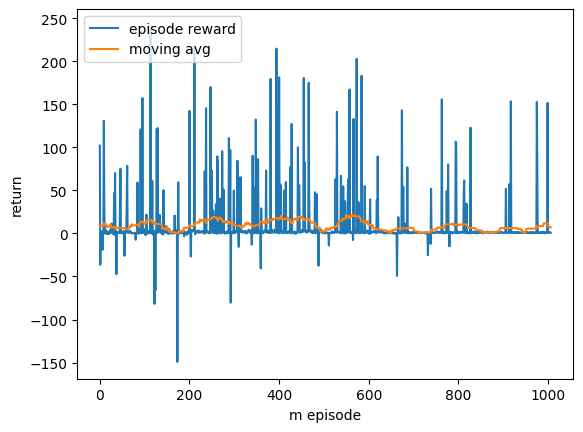

In [35]:
plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
plt.legend(['episode reward', 'moving avg'], loc=2)
plt.xlabel('m episode')
plt.ylabel('return')
plt.show()

In [40]:
task = 'landing'  # 'hover' or 'landing'
max_steps = 800
gamma = 0.99
ckpt_dir = glob.glob(os.path.join(task+'_ckpt', '*.pt'))[-1]  # last ckpt

print(ckpt_dir)
env_test = Rocket(task=task, max_steps=max_steps)
pi_test = PolicyNetwork(env_test.state_dims, env_test.action_dims)
pi_test = pi_test.to(device)
    
if os.path.exists(ckpt_dir):
    checkpoint = torch.load(ckpt_dir, map_location=torch.device(device))
    pi_test.load_state_dict(checkpoint['model_pi_state_dict'])

state = env_test.reset()
episode_returns = list()
for i in range(100):
    _, _, rewards = gen_episode(env_test, pi_test, device, max_steps)
    G = 0
    for t in range(len(rewards) - 2, -1, -1):
        R = rewards[t]
        G = gamma * G + R

    episode_returns.append(G)

average_return = sum(episode_returns) / len(episode_returns)
print(average_return / 120)

landing_ckpt\ckpt_00001000.pt
0.0504469646228965
